In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path

In [41]:
# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Choose parameters
noise_level = "all" # "all",list of int, or int
clean = "avg" # "n2v" or "avg"
display = True # display images and histograms or not
hist_bins = 512
clip = -3 # False or clip value

# Saving dir parameters
noiseModelsDir = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models"
nameHistNoiseModel = f"Hist_Noise{noise_level}_Sig{clean.upper()}_Clip{clip}"
nameGMMNoiseModel = f"GMM_Noise{noise_level}_Sig{clean.upper()}_Clip{clip}"

print(f"Noise level: {noise_level}")
print(f"Clean: {clean}")

print(f"Saving at: {noiseModelsDir}")
print(f"Histogram based noise model saving name: {nameHistNoiseModel}")
print(f"GMM based noise model saving name: {nameGMMNoiseModel}")

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    # n2v or avg signal selection
    if clean == "avg":
        im_signal = imread(data_path_signal / file_signal)[0]
    elif clean == "n2v":
        im_signal = imread(data_path_signal / file_signal)[1]
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        im_obs = imread(data_path_obs / file_obs)[noise_level]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

signal = np.stack(signal)
observation = np.stack(observation)

if len(observation.shape) == 4:
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)


signal = (signal - np.mean(signal))/np.std(signal)
observation = (observation - np.mean(observation))/np.std(observation)


print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")


Noise level: all
Clean: avg
Saving at: E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models
Histogram based noise model saving name: Hist_Noiseall_SigAVG_Clip-3
GMM based noise model saving name: GMM_Noiseall_SigAVG_Clip-3

Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (5, 1416, 1392)
Signal img_and_denoised_08.

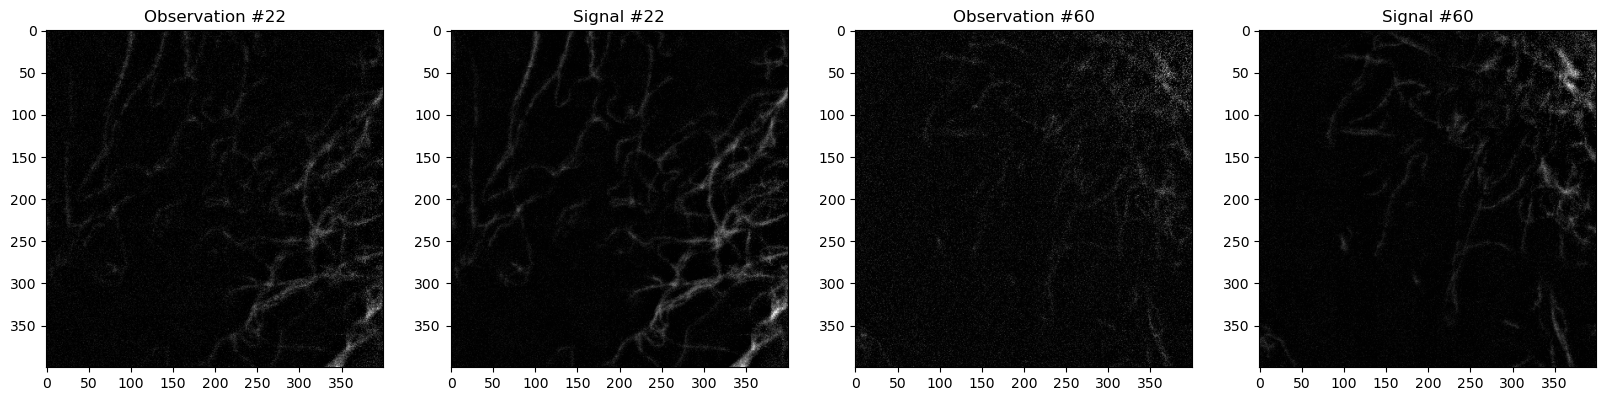

In [42]:
# Display examples of signals and observations if display is set to True

crop_size = 400
h,w = signal[0].shape

starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

if display:
    idxs = np.random.randint(0,observation.shape[0],2)
    plt.figure(figsize=(20,10))
    for i in range(len(idxs)):
        sig = signal[idxs[i],starty:stopy,starty:stopy]
        obs = observation[idxs[i],starty:stopy,starty:stopy]
        plt.subplot(1,4,2*i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation #{idxs[i]}")
        plt.subplot(1,4,2*i+2)
        plt.imshow(sig,cmap="gray")
        plt.title(f"Signal #{idxs[i]}")

Hist noise model saved at E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\Hist_Noiseall_SigAVG_Clip-3


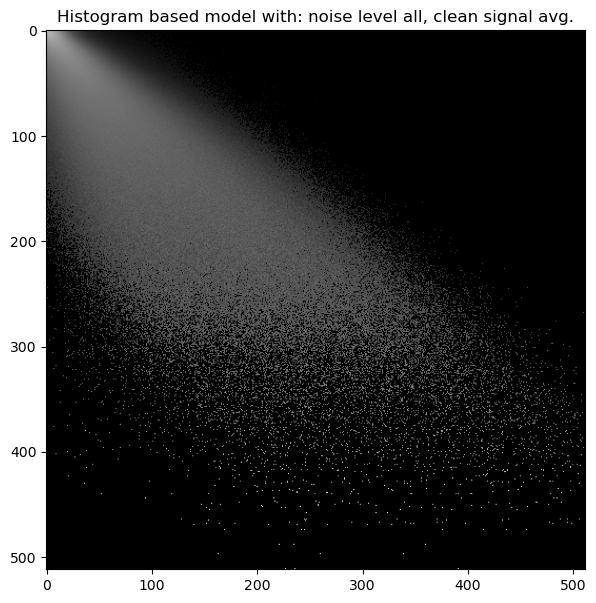

In [43]:
# Create, save and display histogram-based model

plt.figure(figsize=(7,7))
minVal, maxVal = np.min(signal), np.max(signal)
histogram = histNoiseModel.createHistogram(hist_bins, minVal, maxVal, observation,signal)

# Saving histogram
save_path = os.path.join(noiseModelsDir, nameHistNoiseModel)
np.save(save_path, histogram)
print(f"Hist noise model saved at {save_path}")

# Optional display
if display:
    plt.title(f"Histogram based model with: noise level {noise_level}, clean signal {clean}.")
    plt.imshow(histogram[0]**0.25, cmap='gray')
    plt.show()


In [53]:
# Training GMM noise model
n_gaussian = 6# Number of gaussians to use for Gaussian Mixture Model
n_coeff = 7# No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
fullnameGMMNoiseModel = f"/{nameGMMNoiseModel}_nGauss{n_gaussian}_nCoeff{n_coeff}"


gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = minVal,
                                                    max_signal = maxVal,
                                                    path=str(noiseModelsDir), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 1, 
                                                    device = device)

gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 20000, learning_rate=0.1, name = fullnameGMMNoiseModel)

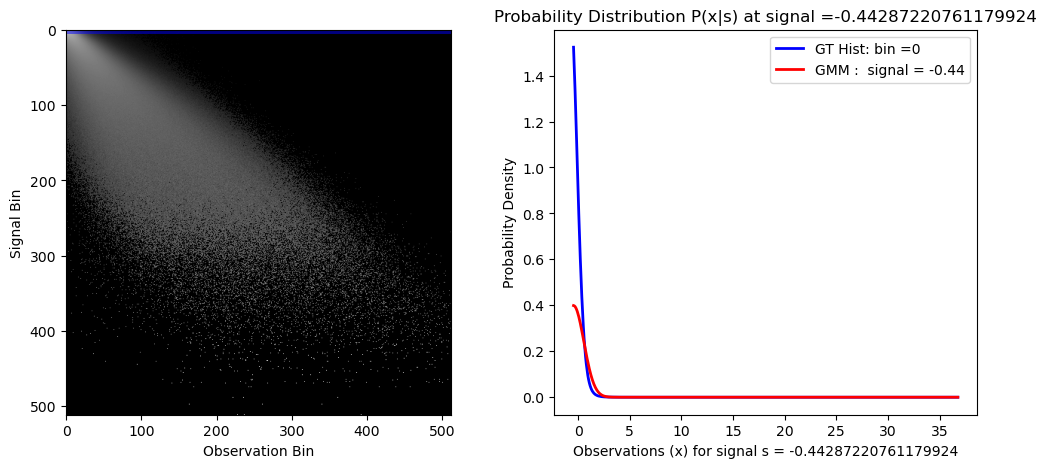

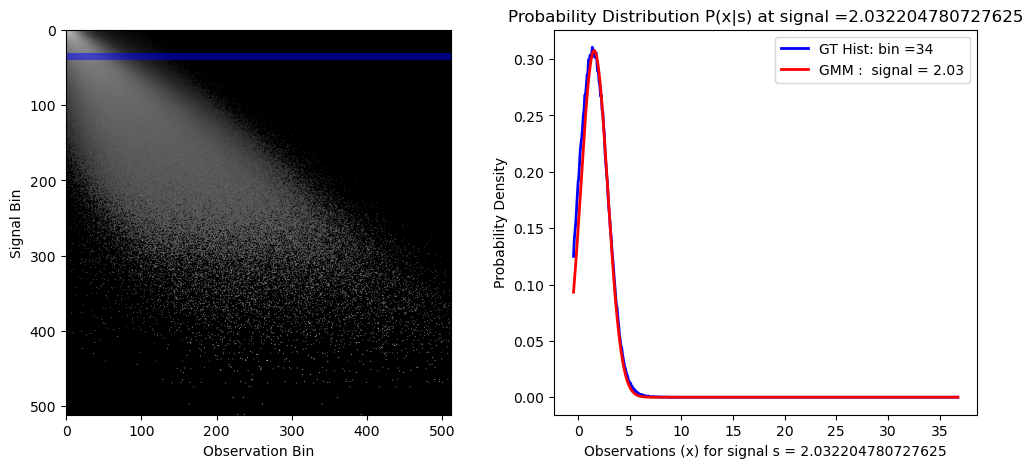

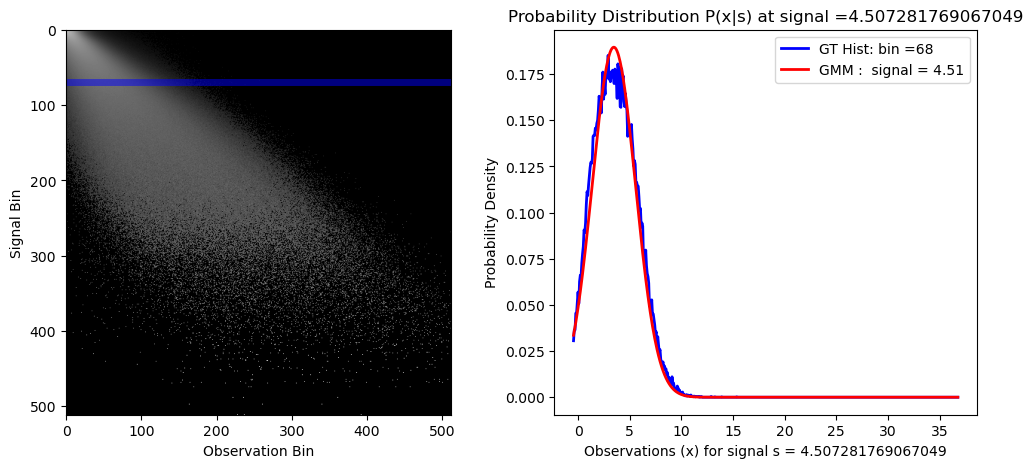

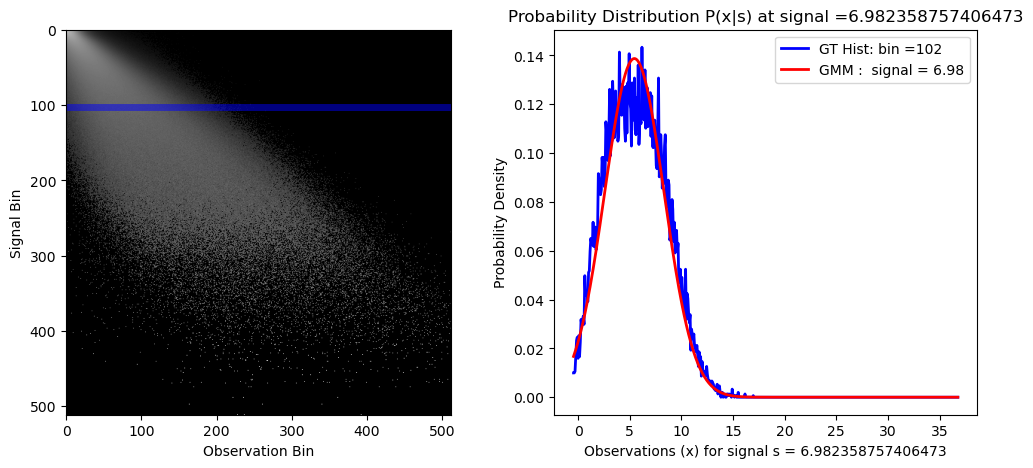

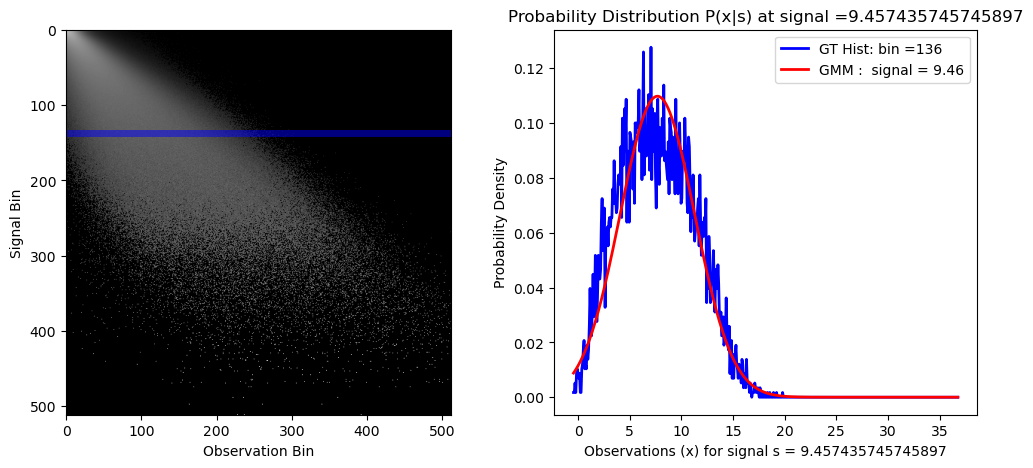

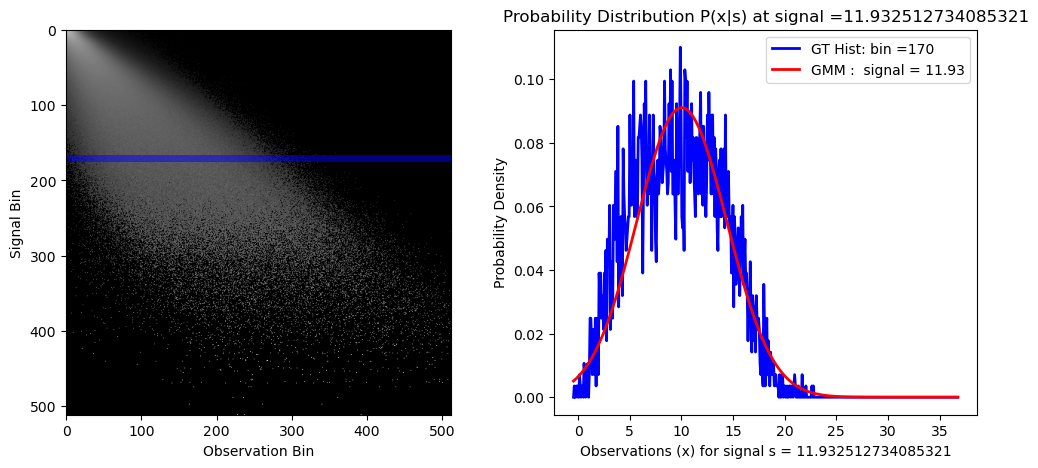

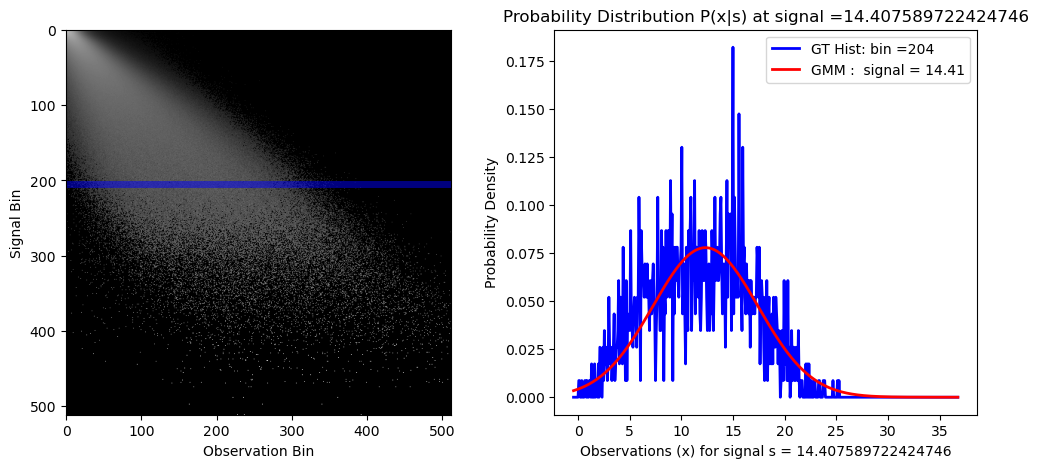

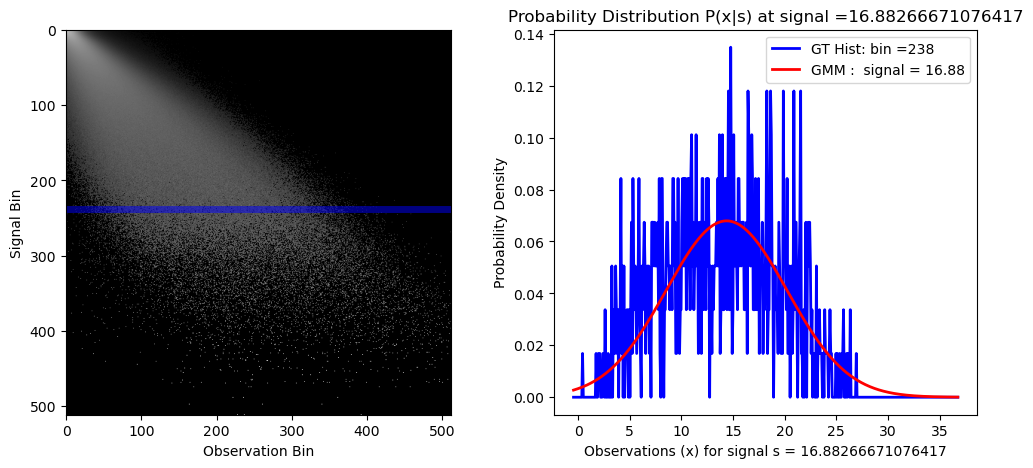

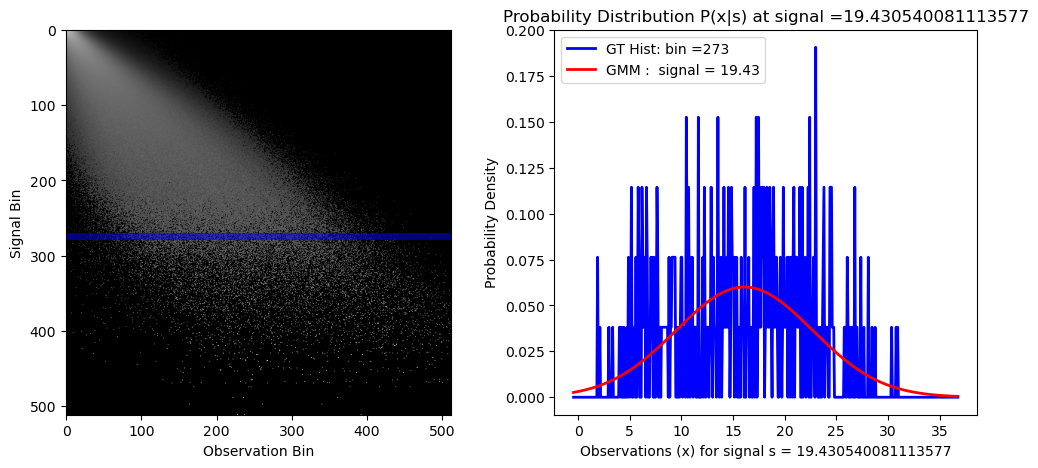

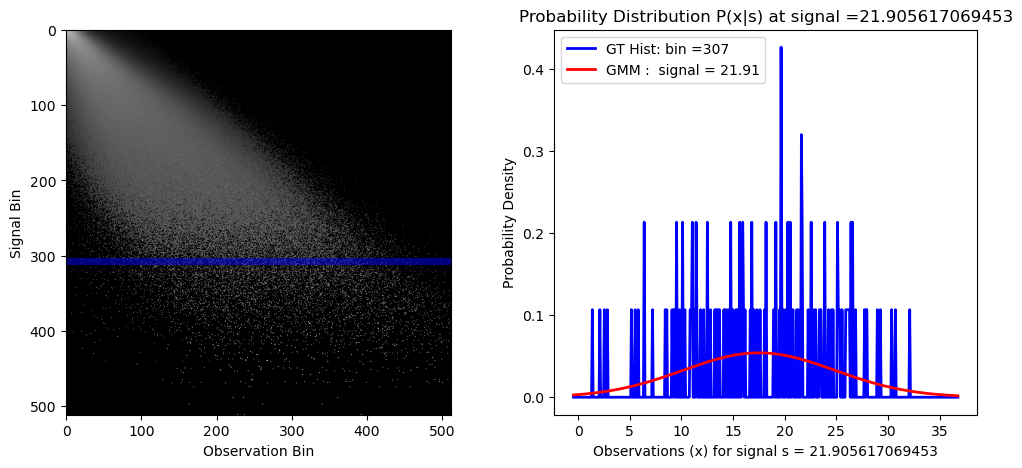

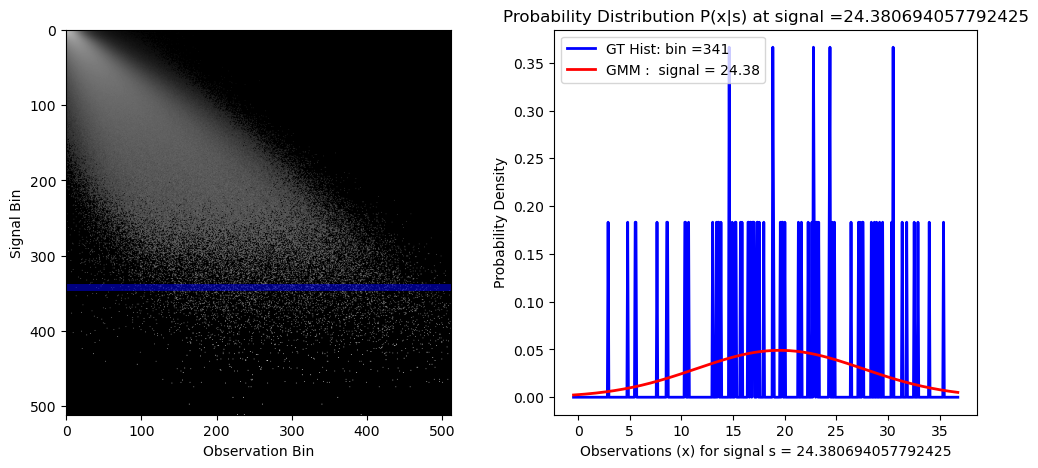

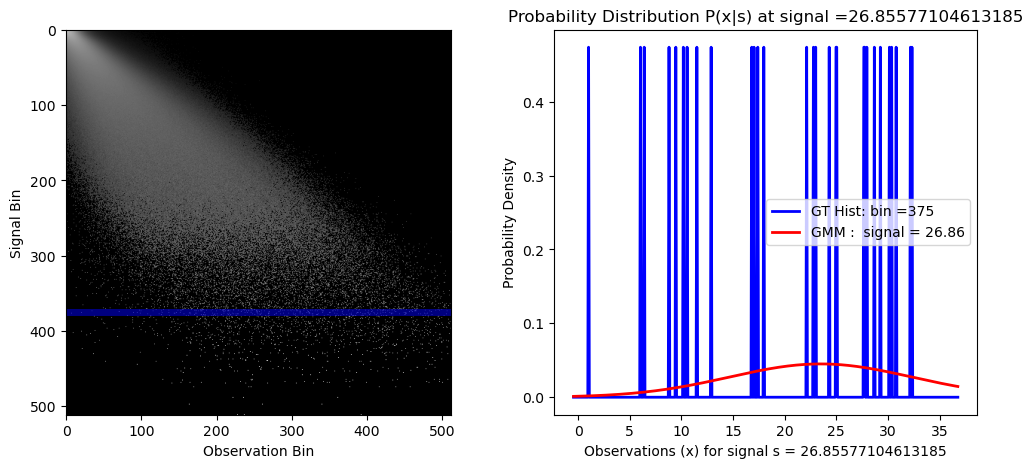

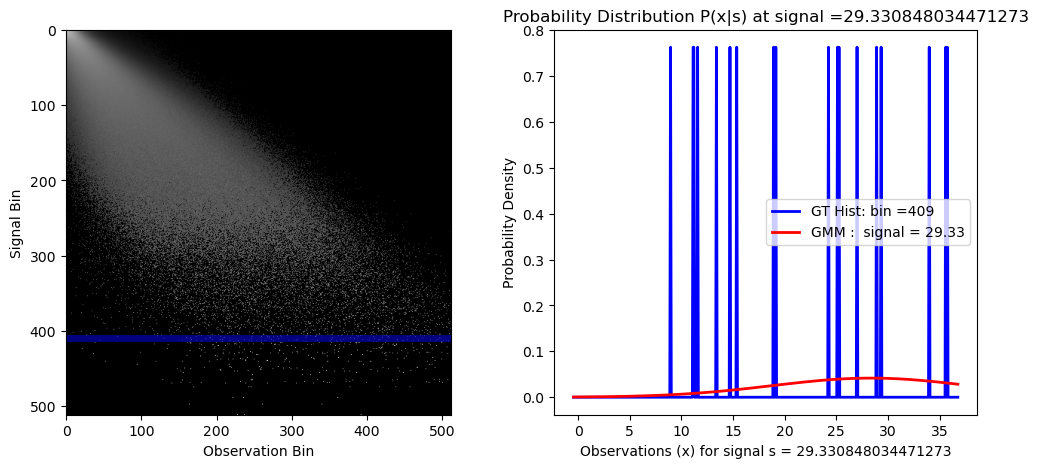

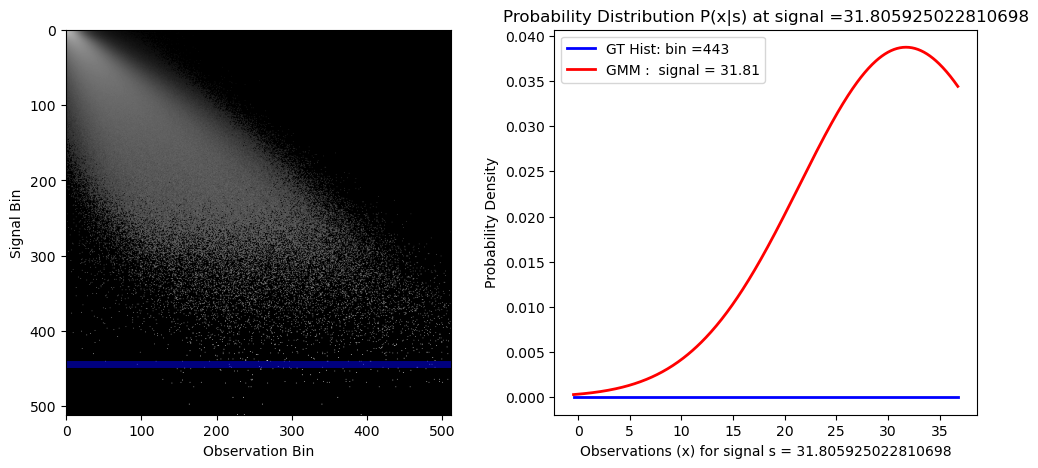

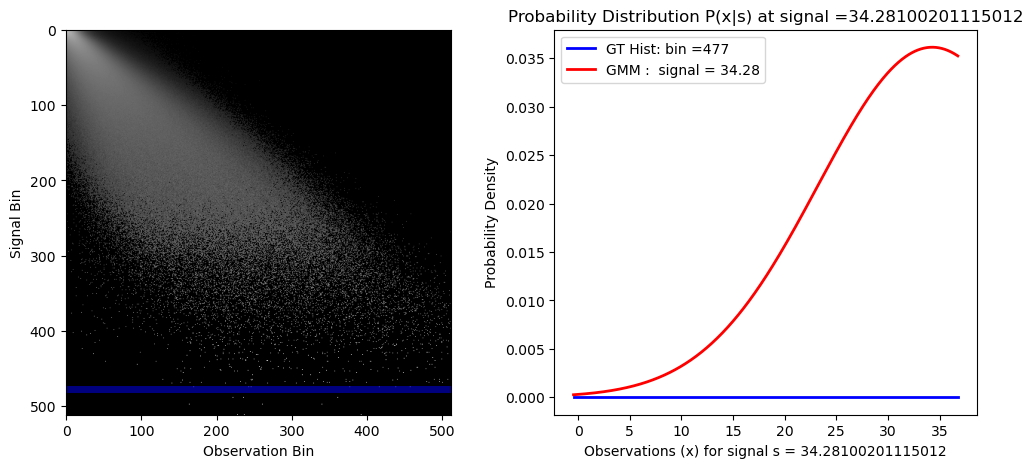

In [52]:
# Check GMM perf
GMMname = fullnameGMMNoiseModel[1::]+".npz" # to check current one
# GMMname = "GMM_Noiseall_SigAVG_Clip-3_nGauss5_nCoeff6.npz"# to check existing one

n_points = 15
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*hist_bins//n_points).astype(int)
GMMmodel_prm = np.load(os.path.join(noiseModelsDir,GMMname))
GMMmodel = GaussianMixtureNoiseModel(params = GMMmodel_prm, device = device) 
for binidx in signalBinIndex_list:
    plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minVal, max_signal=maxVal, n_bin=hist_bins, device=device)